<a href="https://colab.research.google.com/github/noeramlpspta/online_retail/blob/main/User_Retention_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation Data

In [75]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [77]:
df = pd.read_csv('/Online Retail Data.csv')
df

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN
...,...,...,...,...,...,...,...
461768,539991,21618,4 WILDFLOWER BOTANICAL CANDLES,1,2010-12-23 16:49:00,1.25,NaN
461769,539991,72741,GRAND CHOCOLATECANDLE,4,2010-12-23 16:49:00,1.45,NaN
461770,539992,21470,FLOWER VINE RAFFIA FOOD COVER,1,2010-12-23 17:41:00,3.75,NaN
461771,539992,22258,FELT FARM ANIMAL RABBIT,1,2010-12-23 17:41:00,1.25,NaN


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      461773 non-null  object 
 1   product_code  461773 non-null  object 
 2   product_name  459055 non-null  object 
 3   quantity      461773 non-null  int64  
 4   order_date    461773 non-null  object 
 5   price         461773 non-null  float64
 6   customer_id   360853 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 24.7+ MB


# Cleaning Data

In [45]:
# Membuat salinan dari df
df_retail = df.copy()
# Mengonversi kolom order_date menjadi datetime
df_retail['order_date'] = pd.to_datetime(df_retail['order_date'], errors='coerce')
# Membuat kolom year_month
df_retail['year_month'] = df_retail['order_date'].dt.to_period('M')
# Menghapus semua baris tanpa customer_id
df_retail = df_retail[~df_retail['customer_id'].isna()].copy()
# Menghapus semua baris tanpa product_name
df_retail = df_retail[~df_retail['product_name'].isna()].copy()
# Membuat semua product_name berhuruf kecil
df_retail.loc[:, 'product_name'] = df_retail['product_name'].str.lower()
# Menghapus semua baris dengan product_code atau product_name yang mengandung 'test'
df_retail = df_retail[(~df_retail['product_code'].str.lower().str.contains('test', na=False)) |
                      (~df_retail['product_name'].str.contains('test', na=False))].copy()
# Membuat kolom order_status dengan nilai 'cancelled' atau 'delivered'
df_retail.loc[:, 'order_status'] = np.where(df_retail['order_id'].str[:1] == 'C', 'cancelled', 'delivered')
# Mengubah nilai quantity yang negatif menjadi positif
df_retail.loc[:, 'quantity'] = df_retail['quantity'].abs()
# Menghapus baris dengan price bernilai negatif
df_retail = df_retail[df_retail['price'] > 0].copy()
# Membuat nilai amount sebagai perkalian antara quantity dan price
df_retail.loc[:, 'amount'] = df_retail['quantity'] * df_retail['price']
# Memperbarui product_name berdasarkan product_code yang paling sering muncul
most_freq_product_name = (df_retail.groupby(['product_code', 'product_name'], as_index=False)
                          .agg(order_cnt=('order_id', 'nunique'))
                          .sort_values(['product_code', 'order_cnt'], ascending=[True, False]))
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank'] == 1].drop(columns=['order_cnt', 'rank'])
df_retail = df_retail.merge(most_freq_product_name.rename(columns={'product_name': 'most_freq_product_name'}),
                            how='left', on='product_code')
df_retail.loc[:, 'product_name'] = df_retail['most_freq_product_name']
df_retail = df_retail.drop(columns='most_freq_product_name')
# Mengonversi customer_id menjadi string
df_retail['customer_id'] = df_retail['customer_id'].astype(str)
# Menghapus outlier
df_retail = df_retail[(np.abs(stats.zscore(df_retail[['quantity', 'amount']])) < 3).all(axis=1)]
df_retail = df_retail.reset_index(drop=True)
df_retail


,order_id,product_code,product_name,quantity,order_date,price,customer_id,year_month,order_status,amount
0,C493411,21539,red retrospot butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01,cancelled,4.25
1,493414,21844,red retrospot mug,36,2010-01-04 10:28:00,2.55,14590.0,2010-01,delivered,91.80
2,493414,21533,retro spot large milk jug,12,2010-01-04 10:28:00,4.25,14590.0,2010-01,delivered,51.00
3,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,2010-01,delivered,5.10
4,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,2010-01,delivered,8.50
...,...,...,...,...,...,...,...,...,...,...
358464,539988,84380,set of 3 butterfly cookie cutters,1,2010-12-23 16:06:00,1.25,18116.0,2010-12,delivered,1.25
358465,539988,84849D,hot baths soap holder,1,2010-12-23 16:06:00,1.69,18116.0,2010-12,delivered,1.69
358466,539988,84849B,fairy soap soap holder,1,2010-12-23 16:06:00,1.69,18116.0,2010-12,delivered,1.69
358467,539988,22854,cream sweetheart egg holder,2,2010-12-23 16:06:00,4.95,18116.0,2010-12,delivered,9.90


# Membuat User Retention Cohort

In [74]:
df_user_monthly = df_retail.groupby(['customer_id','year_month'], as_index=False).agg(order_cnt=('order_id','nunique'))
df_user_monthly['cohort'] = df_user_monthly.groupby('customer_id')['year_month'].transform('min')

from operator import attrgetter
df_user_monthly['period_num'] = (df_user_monthly['year_month'] - df_user_monthly['cohort']).apply(attrgetter('n')) + 1
df_user_monthly

,customer_id,year_month,order_cnt,cohort,period_num
0,12346.0,2010-01,1,2010-01,1
1,12346.0,2010-03,1,2010-01,3
2,12346.0,2010-06,2,2010-01,6
3,12346.0,2010-10,1,2010-01,10
4,12608.0,2010-10,1,2010-10,1
...,...,...,...,...,...
12039,18286.0,2010-06,1,2010-06,1
12040,18286.0,2010-08,1,2010-06,3
12041,18287.0,2010-05,1,2010-05,1
12042,18287.0,2010-09,2,2010-05,5


# Membuat tabel retention cohort pivot dengan index berupa cohort, kolom berupa jarak bulan, dan nilainya adalah banyaknya pengguna unik (count unique dari ID pengguna)

In [72]:
df_cohort_pivot = pd.pivot_table(df_user_monthly, index='cohort', columns='period_num', values='customer_id', aggfunc=pd.Series.nunique)
df_cohort_pivot.fillna(0, inplace=True)
cohort_size = df_cohort_pivot.iloc[:, 0]
df_retention_cohort = df_cohort_pivot.divide(cohort_size, axis=0)
df_retention_cohort

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,1.0,0.392707,0.468443,0.438990,0.427770,0.426367,0.410940,0.375877,0.399719,0.447405,0.469846,0.349229
2010-02,1.0,0.334056,0.277657,0.349241,0.329718,0.262473,0.258134,0.344902,0.331887,0.360087,0.216920,0.000000
2010-03,1.0,0.276515,0.299242,0.274621,0.265152,0.232955,0.282197,0.352273,0.365530,0.181818,0.000000,0.000000
2010-04,1.0,0.251534,0.230061,0.193252,0.211656,0.242331,0.300613,0.309816,0.153374,0.000000,0.000000,0.000000
2010-05,1.0,0.200730,0.182482,0.189781,0.189781,0.262774,0.244526,0.156934,0.000000,0.000000,0.000000,0.000000
2010-06,1.0,0.199248,0.210526,0.225564,0.244361,0.319549,0.146617,0.000000,0.000000,0.000000,0.000000,0.000000
2010-07,1.0,0.212291,0.206704,0.290503,0.296089,0.167598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-08,1.0,0.218750,0.312500,0.300000,0.168750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-09,1.0,0.281938,0.264317,0.136564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Membuat Heat Map dari pivot diatas

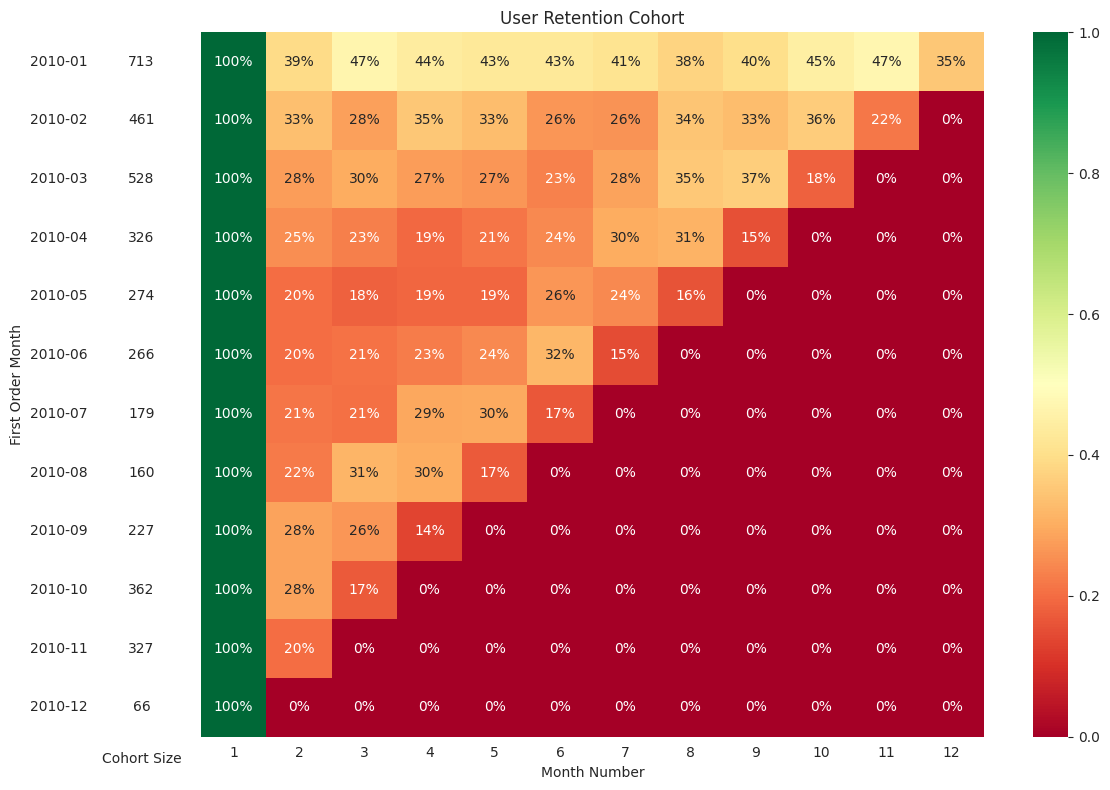

In [73]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

with sns.axes_style('white'):

    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios':[1, 11]})

    # user retention cohort
    sns.heatmap(df_retention_cohort, annot=True, fmt='.0%', cmap='RdYlGn', ax=ax[1])
    ax[1].set_title('User Retention Cohort')
    ax[1].set(xlabel='Month Number', ylabel='')

    # cohort size
    df_cohort_size = pd.DataFrame(cohort_size)
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(df_cohort_size, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0])
    ax[0].tick_params(bottom=False)
    ax[0].set(xlabel='Cohort Size', ylabel='First Order Month', xticklabels=[])

    fig.tight_layout()